In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from python_scripts import bssfp
import os
from scipy.interpolate import interp2d
from scipy.ndimage import convolve

## Section 1: Simulating a phantom with different phase-cycled bSSFP coil images

In [3]:
#Get the main arrays for T1, T2, B0 and flip angle
sqlen = 320
T1 = np.ones((sqlen, sqlen), dtype = 'float')
T2 = np.ones((sqlen, sqlen), dtype = 'float')
B0 = np.ones((sqlen, sqlen), dtype = 'float')
flip_angle = np.deg2rad(22) #in radians
TR = 8.6e-3
npcs = 12
pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
print(np.rad2deg(pcs))

[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330.]


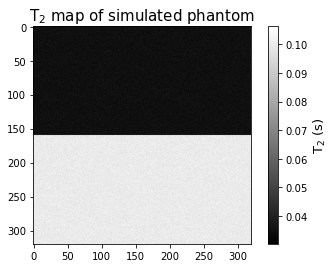

In [17]:
#Set the T2 values
T2[0:int(sqlen/2), :] = 0.0011*np.random.randn(T2[0:int(sqlen/2), :].shape[0], T2[0:int(sqlen/2), :].shape[1]) + 0.035 #in s
T2[int(sqlen/2):, :] = 0.0015*np.random.randn(T2[0:int(sqlen/2), :].shape[0], T2[0:int(sqlen/2), :].shape[1]) + 0.1 #in s

plt.figure()
plt.imshow(np.abs(T2), cmap = 'gray')
cbar = plt.colorbar()
plt.title("T$_2$ map of simulated phantom", fontsize = 15)
cbar.set_label("T$_2$ (s)", fontsize=13)

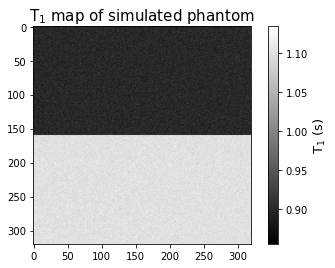

In [18]:
# Set the T1 values
T1[0:int(sqlen/2), :] = 0.010*np.random.randn(T1[0:int(sqlen/2), :].shape[0], T1[0:int(sqlen/2), :].shape[1]) + 0.9 #in s
T1[int(sqlen/2):, :] = 0.008*np.random.randn(T1[0:int(sqlen/2), :].shape[0], T1[0:int(sqlen/2), :].shape[1]) + 1.1 #in s

plt.figure()
plt.imshow(np.abs(T1), cmap = 'gray')
cbar = plt.colorbar()
plt.title("T$_1$ map of simulated phantom", fontsize = 15)
cbar.set_label("T$_1$ (s)", fontsize=13)

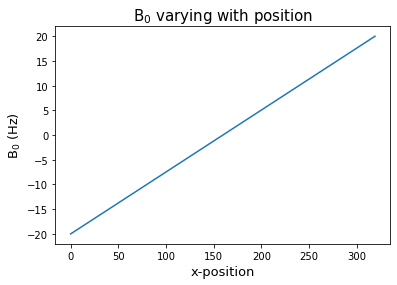

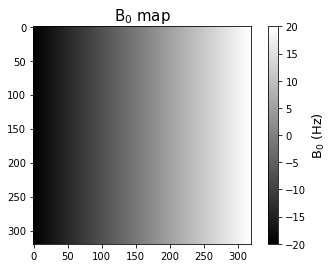

In [13]:
# Set the B0 values
B0_value_change = np.linspace(-20, 20, num = sqlen, endpoint = True) #Hz

plt.figure()
plt.plot(range(sqlen), B0_value_change)
plt.xlabel("x-position", fontsize = 13)
plt.ylabel("B$_0$ (Hz)", fontsize = 13)
plt.title("B$_0$ varying with position", fontsize = 15)

B0[:, :] = np.transpose(B0_value_change)

plt.figure()
plt.imshow(B0, cmap = 'gray')
plt.title("B$_0$ map", fontsize = 15)
cbar = plt.colorbar()
cbar.set_label("B$_0$ (Hz)", fontsize=13)

In [25]:
filepath = r'C:\Users\krith\OneDrive - Imperial College London\PhD\My_papers_writeup\Coil_Combination_paper\data_and_images'
os.chdir(filepath)

np.save("B0.npy", B0)

In [19]:
#Simulating the 12-phase-cycled bSSFP signal
test_image = bssfp.bssfp(T1, T2, TR, flip_angle, B0, pcs)
print(test_image.shape)

test_image = np.moveaxis(test_image, 0, -1)
print(test_image.shape)


(12, 320, 320)
(320, 320, 12)


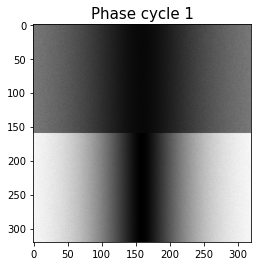

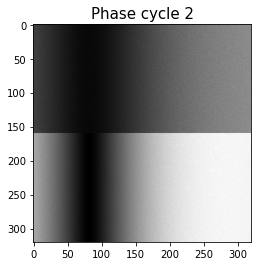

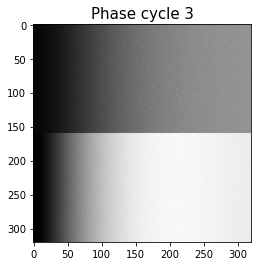

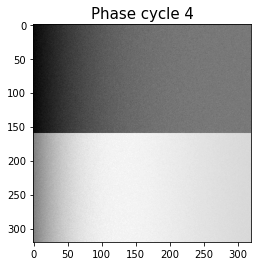

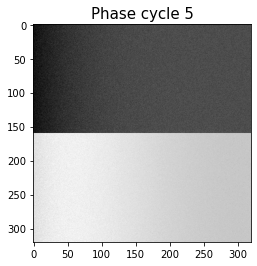

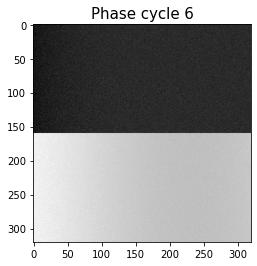

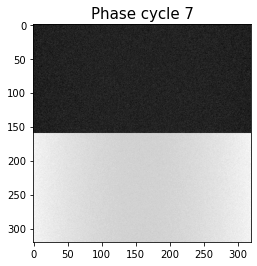

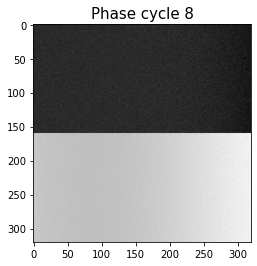

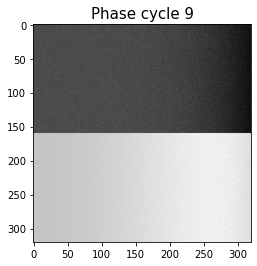

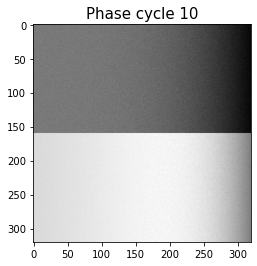

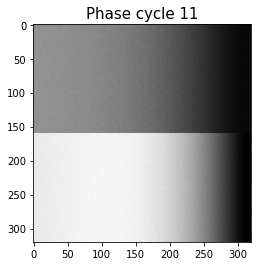

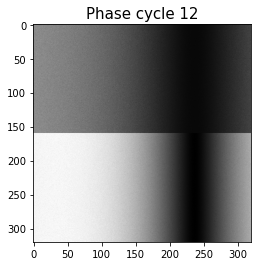

In [21]:
for i in range(test_image.shape[2]):
    plt.figure()
    plt.imshow(np.abs(test_image[:,:,i]), cmap = 'gray')
    plt.title("Phase cycle " + str(i+1), fontsize = 15)

In [10]:
filepath = r'C:\Users\krith\OneDrive - Imperial College London\PhD\My_papers_writeup\Coil_Combination_paper\data_and_images'
os.chdir(filepath)

np.save("test_image.npy", test_image)

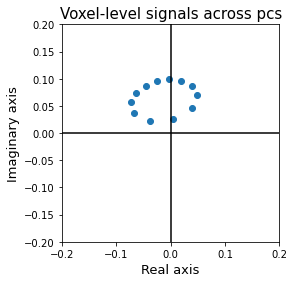

In [25]:
fig, axs = plt.subplots()
axs.scatter(test_image[100,100,:].real, test_image[100,100,:].imag)
axs.set_title('Voxel-level signals across pcs', fontsize = 15)
axs.set_xlabel('Real axis', fontsize = 13)
axs.set_ylabel('Imaginary axis', fontsize = 13)
axs.set_xlim([-0.2,0.2])
axs.set_ylim([-0.2,0.2])
axs.set_aspect(1)
axs.axvline(0, c = 'k')
axs.axhline(0, c = 'k')

In [26]:
#Smooth the image before finding the coil data
# Define a 2D Gaussian kernel for smoothing
def gaussian_kernel(size, sigma=1.0):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    kernel = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    return kernel / np.sum(kernel)

def smooth_a_complex_image(complex_im):
    # Separate the real and imaginary parts
    original_real = complex_im.real
    original_imag = complex_im.imag

    # Apply the Gaussian kernel to the real and imaginary parts separately
    kernel_size = 5  # Adjust the kernel size as needed
    gaussian_kernel_2d = gaussian_kernel(kernel_size)

    smoothed_real = convolve(original_real, gaussian_kernel_2d, mode='nearest')
    smoothed_imag = convolve(original_imag, gaussian_kernel_2d, mode='nearest')

    # Combine the real and imaginary parts to get the smoothed complex matrix
    smoothed_matrix = smoothed_real + 1j * smoothed_imag
    
    return smoothed_matrix

def smooth_bssfp_images(bssfp_coil_im):
    """
    Smoothing phase-cycled bSSFP coil combined images with the gaussian kernel
    Arguments:
    bssfp_coil_im: (row, col, pcs)
    
    Returns:
    smooth_bssfp_matrix: (row, col, pcs)
    """
    
    smooth_bssfp_matrix = np.empty(bssfp_coil_im.shape, dtype = 'complex')
    
    for pc in range(bssfp_coil_im.shape[2]):
        #Smooth the matrix
        smooth_bssfp_matrix[:,:,pc] = smooth_a_complex_image(bssfp_coil_im[:,:,pc])
    
    return smooth_bssfp_matrix



(320, 320, 12)


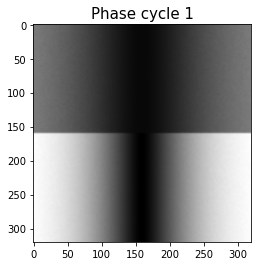

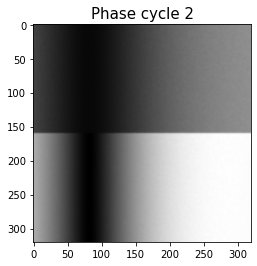

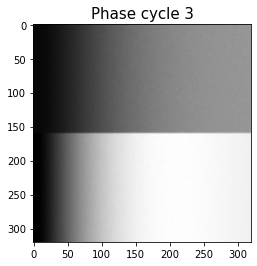

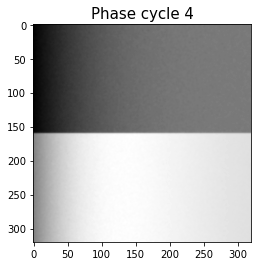

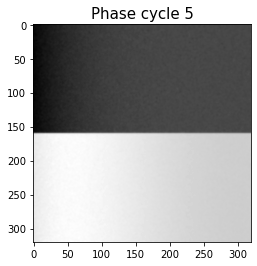

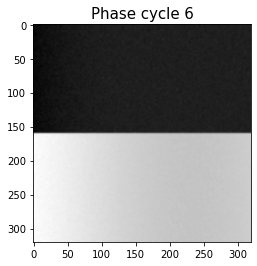

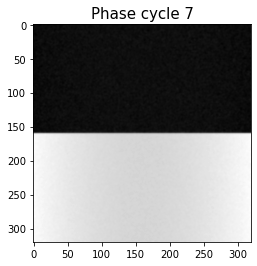

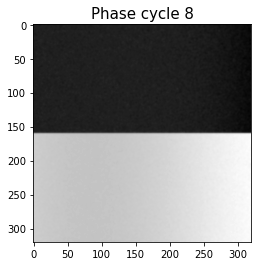

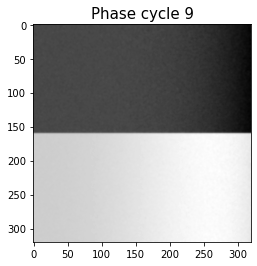

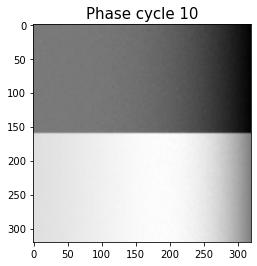

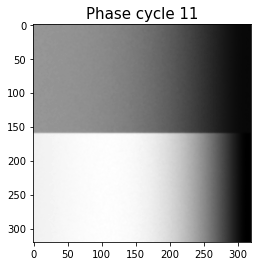

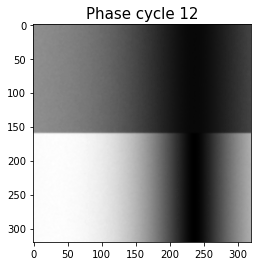

In [28]:
smoothed_bssfp_images = smooth_bssfp_images(test_image)
print(smoothed_bssfp_images.shape)

for i in range(12):
    plt.figure()
    plt.imshow(np.abs(smoothed_bssfp_images[:,:,i]), cmap = 'gray')
    plt.title("Phase cycle " + str(i+1), fontsize = 15)

In [29]:
#Now, need to simulate coil sensitivities for the phantom - use the espirit-estimated coil sensitivities from the knee
#This makes it be as realistic to the CIF as possible. We can later smooth out the images to make sure the final coil 
#sensitivity is a bit different to avoid any biases towards ESPIRIT in the coil combination analysis
filepath = r'D:\MP2\MR_images\28_07_22_healthy_knee_se_bSSFP_sag_ax\coil_comb'
os.chdir(filepath)

esp = np.load('esp_axial1.npy')

In [30]:
esp.shape

(320, 320, 1, 8, 8)

0.8784299
0.0


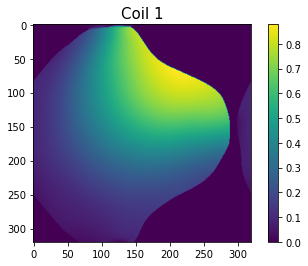

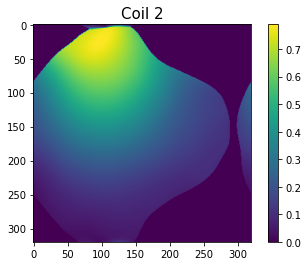

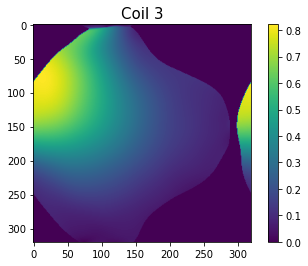

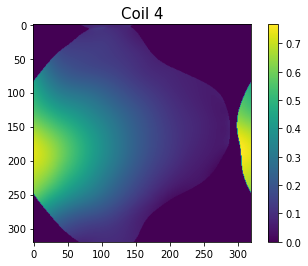

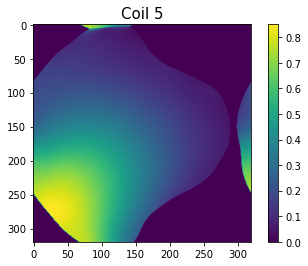

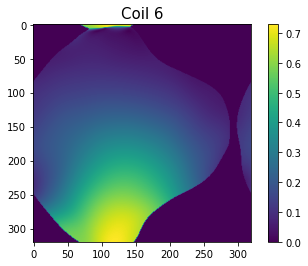

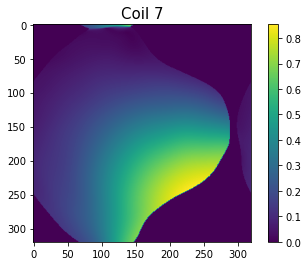

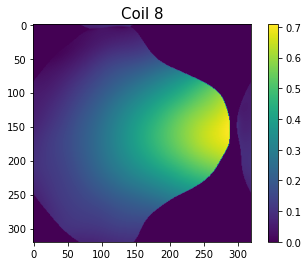

In [31]:
print(np.max(np.abs(esp)))
print(np.min(np.abs(esp)))

for i in range(8):
    plt.figure()
    plt.imshow(np.abs(esp[:,:,0,i,0]))
    plt.title("Coil " + str(i+1), fontsize = 15)
    plt.colorbar()

In [32]:
coil_sensitivities = esp[:,:,0,:,0]
print(coil_sensitivities.shape)

(320, 320, 8)


In [33]:
coil_data = np.empty((smoothed_bssfp_images.shape[0], smoothed_bssfp_images.shape[1], coil_sensitivities.shape[2], 
                      smoothed_bssfp_images.shape[2]), dtype = 'complex')

print(coil_data.shape)

for pc in range(coil_data.shape[3]):
    for c in range(coil_data.shape[2]):
        coil_data[:,:,c,pc] = np.multiply(coil_sensitivities[:,:,c], smoothed_bssfp_images[:,:,pc])

(320, 320, 8, 12)


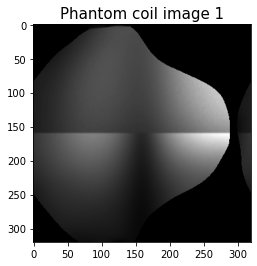

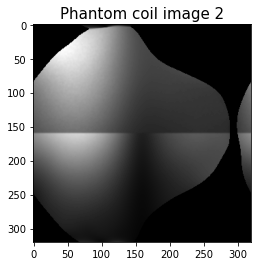

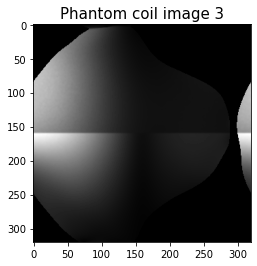

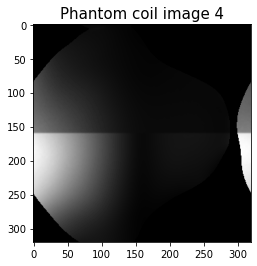

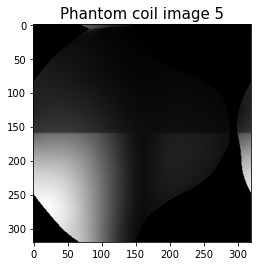

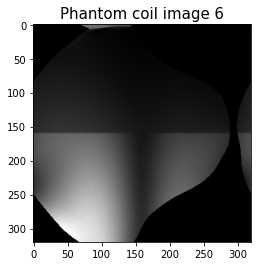

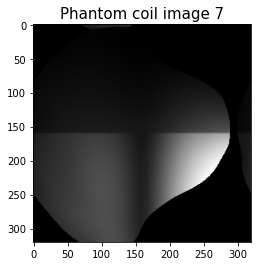

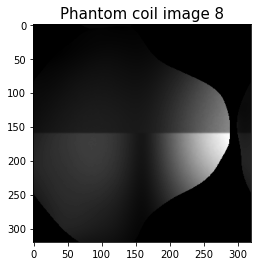

In [36]:
for i in range(8):
    plt.figure()
    plt.imshow(np.abs(coil_data[:,:,i,0]), cmap = 'gray')
    plt.title("Phantom coil image " + str(i+1), fontsize = 15)

In [155]:
filepath = r'D:\MP2\simulated_phantom_data'
os.chdir(filepath)

np.save("simulated_phantom_12pcbssfp_coil_images.npy", coil_data)